# Simulation of the Finnish population development

This project provides overly simplified simulation of the Finnish population development. For example immigration has been excluded totally from the simulation and thus simulated population growth is heavily negative. This simulation is merely for fun.

## Data sources

This simulation initializes itself with official data from [Statistics Finland](https://www.stat.fi/index_en.html).

Initial population distribution of sexes and ages has been generated using following statistics using year 2020:  
StatFin / Population / Population structure / 11rd -- Population according to age (1-year 0-112) and sex, 1972-2021
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__vaerak/statfin_vaerak_pxt_11rd.px/chart/chartViewColumn/

Lifetime simulation uses following statistics using year 2020:  
StatFin / Population / Deaths / 12ap -- Life table by age and sex, 1986-2020  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__kuol/statfin_kuol_pxt_12ap.px/chart/chartViewColumn/

Birth rate simulation uses following statistics using year 2020:  
StatFin / Population / Births / 12dm -- Live births by sex, birth order and age of mother (1-year), 1990-2020  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__synt/statfin_synt_pxt_12dm.px/table/tableViewLayout1/

Code uses convention that whenever dataframe / variable name starts with "stats_" it means that it contains official initial fixed data.

## A results sneak peek

![Animated age by sex over simulations](../images/age_by_sex_distribution_animation.gif?q=3)

## Theory for the simulation

Variables in the model:

$$
\begin{align}
X_{i} & = \textrm{i:th individual in the population} \newline
X_{i,sex} & = \textrm{sex of the i:th individual} \newline
X_{i,age} & = \textrm{age of the i:th individual} \newline
T_{year} & = \textrm{(simulation) year}
\end{align}
$$

### Initial population

Initial population population is generated based on age and sex distribution of the 2020 statistics. There is no randomness / sampling in the procedure to create initial population dataframe. Instead, number of people in each age and sex group is used as is.

### Simulation of lifetime

Lifetime simulation uses death risks by age and sex statistics from the year 2020. This simulation **keeps death risk distribution same over the simulation**:

$$
\begin{align}
P(X_i \textrm{ dies}|T_{year}) & = P(X_i \textrm{ dies}|X_{i,sex},X_{i,age},T_{year}=2020) \newline & = P(X_i \textrm{ dies}|X_{i,sex},X_{i,age})
\end{align}
$$

So death risk is modeled as a function (conditional probability) of sex and age of the individual.

### Simulation of giving birth

Giving birth simulation uses births by mother's age statistics from year 2020. This simulation **keeps the birth distribution same over the simulation**:

$$
\begin{align}
P(X_i \textrm{ gives birth}|T_{year}) & = P(X_i \textrm{ gives birth}|X_{i,sex}=1,X_{i,age},T_{year}=2020) \newline
& = P(X_i \textrm{ gives birth}|X_{i,sex},X_{i,age})
\end{align}
$$

Trivially:

$$
\begin{gather}
P(X_i \textrm{ gives birth}|X_{i,sex}=0) = 0
\end{gather}
$$

So birth is modeled as a function (conditional probability) of sex and age of the individual.

#### Simulation of the sex of a newborn baby

Approximately half of the newborn babies are males and the other half are females. Actually, there are slightly more male newborn babies than female newborn babies. From the official statistics wee see that:

$$
\begin{gather}
P(\textrm{Newborn baby is male}) = 0.511
\end{gather}
$$

It is quite reasonable assumption that this probability does not change over time or does not depend on mother's age.

## Code / Implementation

### Forewords

Most of the simulation modeling could have been achieved with way smaller sample sizes than actual Finnish population size (over 5 million rows) as used here. Actually many results of the simulation could have been achieved with pure modelling calculations without sampling. So why this simulation uses (big) samples:

1. To enable further development for game like society simulation playground with ability to individual tracking.
2. To enable explorations with sampling, kernel density estimation, Monte Carlo estimation, well performing vectorized operations, etc (=fun)

### Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KernelDensity


sns.set_theme()

### Constants

In [2]:
class Cfg:
    DATA_DIR = os.path.join(os.pardir, 'data')
    IMAGE_DIR = os.path.join(os.pardir, 'images')
    
    # If running this notebook can overwrite previous image results
    OVERWRITE_IMAGES = True
    
    # Dimensions for plotting
    A4_DIMS = (15, 6)
    
    # 0 = male, 1 = female
    SEXES = [0, 1] 
    MAX_AGE = 120
    
    # Initial year (starting from). Should not be changed since we uses statistcs from year 2020.
    INITIAL_YEAR = 2020
    # End / Target year of the simulation. Should be greater than 2020.
    TARGET_YEAR = 2021
    
    # Probability that single baby is male. Female probability is 1-MALE_BIRTH_PROBABILITY.
    MALE_BIRTH_PROBABILITY = 0.511
    

# Set initial fixed seed for reproducibility
np.random.seed(Cfg.INITIAL_YEAR)

### Animation utils

In [3]:
def animate_gif(filenames, output_filename, remove_original_images=False):
    output_file = os.path.join(Cfg.IMAGE_DIR, output_filename)
    if os.path.exists(output_filename) and not Cfg.OVERWRITE_IMAGES:
        raise Exception(f"Image {output_filename} already exists!")
    # build gif
    filenames = [os.path.join(Cfg.IMAGE_DIR, filename) for filename in filenames]
    with imageio.get_writer(output_file, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove original images
    if remove_original_images:
        for filename in set(filenames):
            os.remove(filename)

### Population stats by age and sex

Initial population distribution of sexes and ages has been generated using following statistics using year 2020:  
StatFin / Population / Population structure / 11rd -- Population according to age (1-year 0-112) and sex, 1972-2021  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__vaerak/statfin_vaerak_pxt_11rd.px/chart/chartViewColumn/

In [4]:
stats_population_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '004_11rd_2020_20220319-004320.csv'), encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_population_dataframe(df):
    df['sex'] = df['Sukupuoli'].apply(lambda x: 1 if x == 'Miehet' else 0)
    df = df.rename(columns={'2020': 'population_count', 'Ikä': 'age'})
    df = df.drop(df.columns.difference(['sex', 'population_count', 'age']), 1)
    return df


stats_population_df = tilastokeskus_transform_population_dataframe(stats_population_df)

stats_population_df.head()

,age,population_count,sex
0,0,23806,1
1,1,23459,1
2,2,25012,1
3,3,26298,1
4,4,27634,1


In [5]:
def plot_population_age_distributions_by_sex(df, title_year=None, aggregated=True, save_with_filename=None):
    fig, ax = plt.subplots(1, 2, figsize=Cfg.A4_DIMS)
    for a in ax:
        a.set_ylim(top=45000)
    if not aggregated:
        df = df.groupby(['sex', 'age']).size().reset_index(name='population_count')
    males = df[df['sex'] == 1]
    females = df[df['sex'] == 0]
    mp = sns.histplot(x=males['age'], weights=males['population_count'], binrange=(0, Cfg.MAX_AGE), binwidth=1, ax=ax[0])
    mp.set_title(f"Age distribution of males{' - {}'.format(title_year) if title_year else ''}")
    fp = sns.histplot(x=females['age'], weights=females['population_count'],  binrange=(0, Cfg.MAX_AGE), binwidth=1, ax=ax[1])
    fp.set_title(f"Age distribution of females{' - {}'.format(title_year) if title_year else ''}")
    
    if save_with_filename:
        filepath = os.path.join(Cfg.IMAGE_DIR, save_with_filename)
        if os.path.exists(filepath) and not Cfg.OVERWRITE_IMAGES:
            raise Exception(f"Image {save_with_filename} already exists")
        plt.savefig(filepath)

    fig.show()

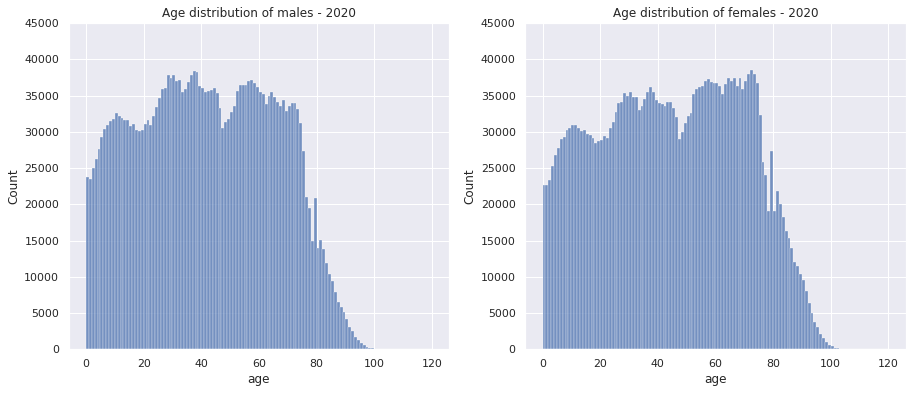

In [6]:
plot_population_age_distributions_by_sex(stats_population_df, title_year=2020, save_with_filename="age_by_sex_distribution_2020.png")

### Lifetime stats by age and sex

Lifetime simulation uses following statistics using year 2020:  
StatFin / Population / Deaths / 12ap -- Life table by age and sex, 1986-2020  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__kuol/statfin_kuol_pxt_12ap.px/chart/chartViewColumn/

In [7]:
stats_lifetime_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '002_12ag_2020_20220318-232408.csv'), encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_lifetime_dataframe(df):
    df['sex'] = df['Sukupuoli'].apply(lambda x: 1 if x == 'Miehet' else 0)
    df = df.rename(columns={'2020': 'dead_count', 'Ikä': 'age'})
    df = df.drop(df.columns.difference(['sex', 'dead_count', 'age']), 1)
    return df

stats_lifetime_df = tilastokeskus_transform_lifetime_dataframe(stats_lifetime_df)

stats_lifetime_df.head()

,age,dead_count,sex
0,0,49,1
1,1,5,1
2,2,2,1
3,3,3,1
4,4,5,1


In [8]:
def plot_lifetime_distributions_by_sex(df, title_year=2020):
    fig, ax = plt.subplots(1, 2, figsize=Cfg.A4_DIMS)
    males = df[df['sex'] == 1]
    females = df[df['sex'] == 0]
    mp = sns.histplot(data=males, x=males['age'], weights=males['dead_count'], binwidth=1, ax=ax[0])
    mp.set_title(f"Lifetime distribution of males - {title_year}")
    fp = sns.histplot(data=females, x=females['age'], weights=females['dead_count'], binwidth=1, ax=ax[1])
    fp.set_title(f"Lifetime distribution of females - {title_year}")
    fig.show()

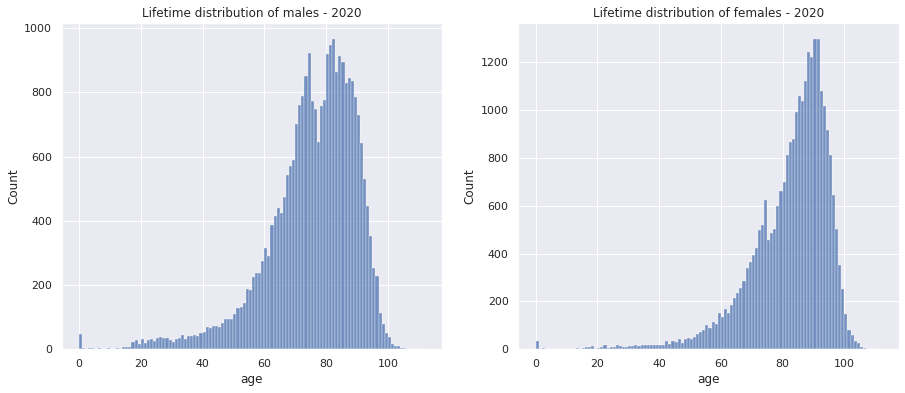

In [9]:
plot_lifetime_distributions_by_sex(stats_lifetime_df)

### Risk of death stats by age and sex

Lifetime simulation uses following statistics using year 2020:  
StatFin / Population / Deaths / 12ap -- Life table by age and sex, 1986-2020  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__kuol/statfin_kuol_pxt_12ap.px/chart/chartViewColumn/

In [10]:
stats_death_risk_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '008_12ap_2020_20220321-001345.csv'), 
                                  encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_deathrisk_dataframe(df):
    df['sex'] = df['Sukupuoli'].apply(lambda x: 1 if x == 'Miehet' else 0)
    df = df.rename(columns={'2020': 'death_probability', 'Ikä': 'age'})
    df['death_probability'] = df['death_probability'].apply(pd.to_numeric, errors='coerce')
    df['death_probability'] = df['death_probability'] / 1000
    df = df.drop(df.columns.difference(['sex', 'death_probability', 'age']), 1)
    df = df.dropna()
    return df

stats_death_risk_df = tilastokeskus_transform_deathrisk_dataframe(stats_death_risk_df)

stats_death_risk_df.head()

,age,death_probability,sex
0,0,0.00206,1
1,1,0.00020,1
2,2,0.00008,1
3,3,0.00011,1
4,4,0.00018,1


In [11]:
def plot_risk_of_death_distributions_by_sex(df):
    fig, ax = plt.subplots(1, 2, figsize=Cfg.A4_DIMS)
    males = df[df['sex'] == 1]
    females = df[df['sex'] == 0]
    mp = sns.histplot(x=males['age'], weights=males['death_probability'], binrange=(males['age'].min(), males['age'].max() + 1), binwidth=1, ax=ax[0])
    mp.set_title("Death risk of males - 2020")
    ax[0].set(ylabel='probability')
    fp = sns.histplot(x=females['age'], weights=females['death_probability'], binrange=(females['age'].min(), females['age'].max() + 1), binwidth=1, ax=ax[1])
    fp.set_title("Death risk of females - 2020")
    ax[1].set(ylabel='probability')
    fig.show()

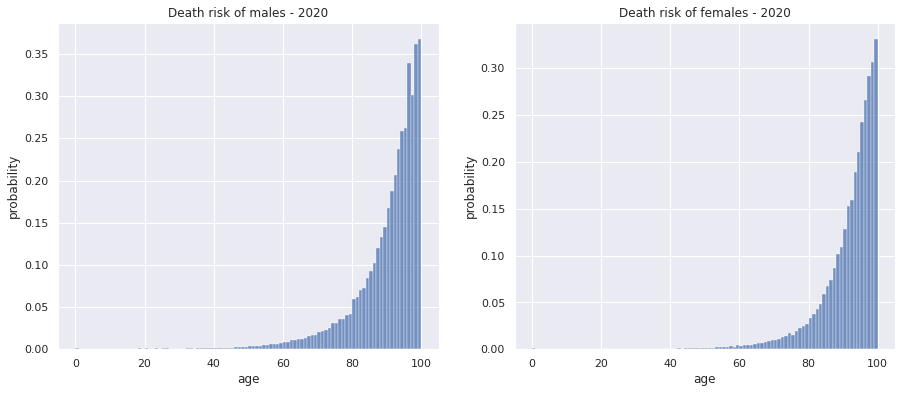

In [12]:
plot_risk_of_death_distributions_by_sex(stats_death_risk_df)

To support vectorized operations we create dictionary with key combined of sex and age. Because during 2020 there were no deaths on every old age up to max age (=120) we prefill those ages' death risk as equal with given greatest death age. We also make sure that death occurs for sure in the simulation at the age of simulation max age (=120) to make simulation reasonable and well behaving.

In [13]:
SEX_AGE_INDEX_GAP = 1000

assert SEX_AGE_INDEX_GAP > Cfg.MAX_AGE

# Sex and age to index value
def get_sex_age_index_value(sex, age):
    return sex * SEX_AGE_INDEX_GAP + age

# Inverse for get_sex_age_index_value
def sex_and_age_from_index_value(sex_age_index_value):
    return (int(sex_age_index_value >= SEX_AGE_INDEX_GAP), sex_age_index_value % SEX_AGE_INDEX_GAP)


death_probability_by_sex_and_age_index = {}
death_probability_by_sex_and_age = {0: {}, 1: {}}
for _, row in stats_death_risk_df.iterrows():
    death_probability_by_sex_and_age[row['sex']][row['age']] = row['death_probability']

# TODO this is simple prefill assuming death risk is constant after -> use increasing death risk
for sex in Cfg.SEXES:
    given_max_age = int(max(death_probability_by_sex_and_age[sex].keys()))
    for age in range(given_max_age + 1, Cfg.MAX_AGE + 1):
        death_probability_by_sex_and_age[sex][age] =  death_probability_by_sex_and_age[sex][given_max_age]
    # Let's make sure that there is upper limit for the age
    death_probability_by_sex_and_age[sex][Cfg.MAX_AGE] = 1

for sex in death_probability_by_sex_and_age:
    for age in death_probability_by_sex_and_age[sex]:
        death_probability_by_sex_and_age_index[get_sex_age_index_value(sex, age)] = death_probability_by_sex_and_age[sex][age]

### Fertility stats

Birth rate simulation uses following statistics using year 2020:  
StatFin / Population / Births / 12dm -- Live births by sex, birth order and age of mother (1-year), 1990-2020  
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__synt/statfin_synt_pxt_12dm.px/table/tableViewLayout1/

Here we make following simplifications:

1. If range given for mother age is like 0-14 then we simplify that all mothers have age of 14.
2. If range given for mother age is like 55- then we simplify that all mothers have age of 55.
3. This concludes that in this case ages 0-13 and 55+ have zero fertility rate.

In [46]:
stats_fertility_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '005_12dm_2020_20220318-232741.csv'), 
                                  encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_fertility_dataframe(df, population_df):
    def transform_mother_age(age_str):
        if age_str.isnumeric():
            return int(age_str)
        if '-' in age_str:
            lowest_age_in_range_str = age_str.split('-')[0].strip()
            biggest_age_in_range_str = age_str.split('-')[-1].strip()
            if biggest_age_in_range_str:
                return transform_mother_age(biggest_age_in_range_str)
            elif lowest_age_in_range_str:
                return transform_mother_age(lowest_age_in_range_str)
        raise ValueError(f"Cannot parse age out of {age_str}")
    
    def apply_female_population_count_by_row(row):
        population_count = population_df[(population_df['sex'] == 1) & (population_df['age'] == row['mother_age'])]['population_count']
        assert len(population_count) == 1
        population_count = population_count.iloc[0]
        return population_count
        
    df['mother_age'] = df['Äidin ikä'].apply(transform_mother_age)
    
    df['total_number_of_children_born'] = df['Miehet Elävänä syntyneet'] + df['Naiset Elävänä syntyneet']
    df = df.drop(df.columns.difference(['mother_age', 'total_number_of_children_born']), 1)
    df = df.dropna()
    
    df['female_population_count'] = df.apply(apply_female_population_count_by_row, axis=1)
    df['birth_probability'] = df['total_number_of_children_born'] / df['female_population_count']
    
    return df

stats_fertility_df = tilastokeskus_transform_fertility_dataframe(stats_fertility_df, stats_population_df)

stats_fertility_df.head()

,mother_age,total_number_of_children_born,female_population_count,birth_probability
0,14,3,31642,0.000095
1,15,9,30796,0.000292
2,16,28,31133,0.000899
3,17,59,30309,0.001947
4,18,162,30052,0.005391


In [15]:
# Babies born in 2020
print(f"Babies born in {Cfg.INITIAL_YEAR}: {stats_fertility_df['total_number_of_children_born'].sum()}")

Babies born in 2020: 46463


Create birth probability index for vectorized operations

In [47]:
birth_probability_by_age = {}
for _, row in stats_fertility_df.iterrows():
    birth_probability_by_age[row['mother_age']] = row['birth_probability']

for age in range(0, Cfg.MAX_AGE + 1):
    if age not in birth_probability_by_age:
        birth_probability_by_age[age] = 0

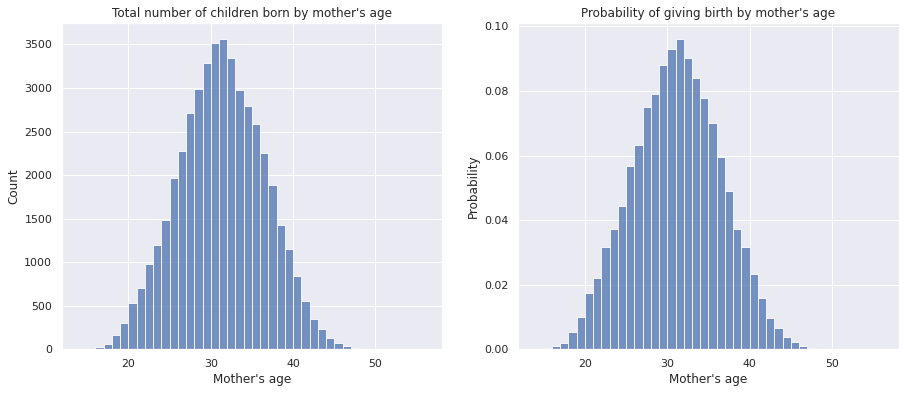

In [48]:
def plot_fertility_by_age(df, aggregated=False):
    fig, ax = plt.subplots(1, 2, figsize=Cfg.A4_DIMS)
    plot_df = df
    histogram1 = sns.histplot(x=plot_df['mother_age'], weights=plot_df['total_number_of_children_born'], binrange=(plot_df['mother_age'].min(), plot_df['mother_age'].max() + 1), binwidth=1, ax=ax[0])
    histogram1.set_title("Total number of children born by mother's age")
    histogram1.set(xlabel="Mother's age")
    histogram1.set(ylabel="Count")
    
    histogram2 = sns.histplot(x=plot_df['mother_age'], weights=plot_df['birth_probability'], binrange=(plot_df['mother_age'].min(), plot_df['mother_age'].max() + 1), binwidth=1, ax=ax[1])
    histogram2.set_title("Probability of giving birth by mother's age")
    histogram2.set(xlabel="Mother's age")
    histogram2.set(ylabel="Probability")
plot_fertility_by_age(stats_fertility_df, aggregated=True)

### Initialize simulation population

In [17]:
# TODO move this to Cfg for customizability
INITIAL_POPULATION_SIZE = stats_population_df['population_count'].sum()

print(f"Initial population size in {Cfg.INITIAL_YEAR}: {INITIAL_POPULATION_SIZE}")

def create_initial_population(stats_population_df):
    ages = np.zeros(INITIAL_POPULATION_SIZE, dtype=int)
    sexes = np.zeros(INITIAL_POPULATION_SIZE, dtype=int)
    # This is artificial index so that we can utilize vectorized operations for the dataframe (millions of rows are too slow without vectorization)
    sex_age_index = np.zeros(INITIAL_POPULATION_SIZE, dtype=int)

    start_idx = 0
    for _, row in stats_population_df.iterrows():
        end_idx = start_idx + row['population_count']
        ages[start_idx:end_idx] = np.repeat(row['age'], row['population_count'])
        sexes[start_idx:end_idx] = np.repeat(row['sex'], row['population_count'])
        sex_age_index[start_idx:end_idx] = np.repeat(get_sex_age_index_value(row['sex'], row['age']), row['population_count'])
        start_idx = end_idx

    df = pd.DataFrame({'age': ages, 'sex': sexes, 'sex_age_index': sex_age_index})
    dead_df = pd.DataFrame().reindex(columns=df.columns)
    dead_df['death_year'] = pd.Series([], dtype=int)
    
    return df, dead_df


df, dead_df = create_initial_population(stats_population_df)

Initial population size in 2020: 5533793


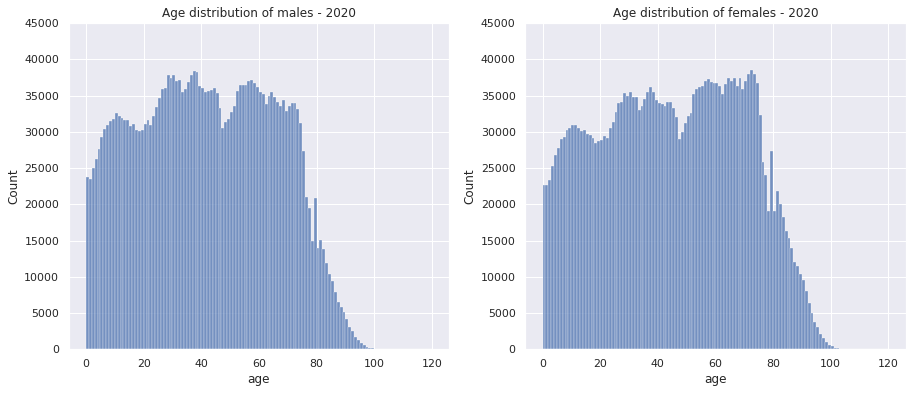

In [18]:
plot_population_age_distributions_by_sex(df, title_year=2020, aggregated=False)

## Simulation

In [19]:
def simulate_one_year(df, dead_df, year):
    df['random'] = np.random.random(len(df))
    # Get conditional probability of death conditioned on sex
    df['death_probability'] = df['sex_age_index'].map(lambda idx_value: death_probability_by_sex_and_age_index[idx_value])
    dead = df.loc[df['random'] < df['death_probability'], :].copy()
    dead['death_year'] = year
    dead_df = dead_df.append(dead, ignore_index=True)
    df.drop(dead.index, inplace=True)
    # Update ages and related indexes and probabilities
    df['age'] += 1
    df['sex_age_index'] += 1
    
    df['random'] = np.random.random(len(df))
    # Get conditional probability of giving birth conditioned on age
    df['birth_probability'] = df.loc[df['sex'] == 1]['age'].apply(lambda age: birth_probability_by_age[age])
    # Fill zero for males
    df['birth_probability'] = df['birth_probability'].fillna(0)
    newborn_count = len(df[df['random'] < df['birth_probability']])
    
    ages = np.zeros(newborn_count, dtype=int)
    sexes = np.zeros(newborn_count, dtype=int)
    sex_age_index = np.zeros(newborn_count, dtype=int)
    newborn_females_index = round(newborn_count * Cfg.MALE_BIRTH_PROBABILITY)
    sexes[newborn_females_index:] = 1
    sex_age_index[:newborn_females_index] = get_sex_age_index_value(0, 0)
    sex_age_index[newborn_females_index:] = get_sex_age_index_value(1, 0)

    newborn_df = pd.DataFrame({'age': ages, 'sex': sexes, 'sex_age_index': sex_age_index})
    # TODO this resets index - newborn_df index should be adjusted by starting from max+1 of the df index
    df = pd.concat([df, newborn_df], ignore_index=True)
    
    return df, dead_df


def simulate_until(target_year, df, dead_df):
    results = {'population_development': {
        Cfg.INITIAL_YEAR: {
            'total': len(df),
            'males': len(df[df['sex'] == 0]),
            'females': len(df[df['sex'] == 1])
        }
    }}
    for year in range(Cfg.INITIAL_YEAR + 1, target_year + 1):
        # Set fixed seed for the year
        np.random.seed(year)
        df, dead_df = simulate_one_year(df, dead_df, year)
        results['population_development'][year] = {
            'total': len(df),
            'males': len(df[df['sex'] == 0]),
            'females': len(df[df['sex'] == 1])
        }
        plot_population_age_distributions_by_sex(df, title_year=year, aggregated=False, save_with_filename=f'age_by_sex_distribution_{year}.png')
    return df, dead_df, results

In [20]:
# We do not show all intermediate graphs so let's not plot them
%matplotlib agg

plot_population_age_distributions_by_sex(stats_population_df, title_year=2020, save_with_filename="age_by_sex_distribution_2020.png")

assert Cfg.INITIAL_YEAR == 2020
assert Cfg.TARGET_YEAR > Cfg.INITIAL_YEAR

# Create initial population df and df for dead
df, dead_df = create_initial_population(stats_population_df)

# Run simulation
df, dead_df, results = simulate_until(Cfg.TARGET_YEAR, df, dead_df)

# Animate results
animate_gif([f'age_by_sex_distribution_{year}.png' for year in range(Cfg.INITIAL_YEAR, Cfg.TARGET_YEAR + 1)], 'age_by_sex_distribution_animation.gif')

# Put back inline plotting
%matplotlib inline

## Results of the simulation

### Animation of population distribution over time
![Animated age by sex over simulations](../images/age_by_sex_distribution_animation.gif?q=3)

### Development of population over time

In [21]:
def plot_population_development(results):
    data = results['population_development']
    # TODO this is global I guess? If so move elsewhere
    sns.set(rc={'figure.figsize':(15, 6)})
    years = list(data.keys())
    totals = [data[year]['total'] for year in data]
    males = [data[year]['males'] for year in data]
    females = [data[year]['females'] for year in data]
    plot_df = pd.DataFrame({'year': years, 'total': totals, 'males': males, 'females': females})
    g = sns.lineplot(data=pd.melt(plot_df, ['year']), x='year', y='value', hue='variable')
    plt.xticks(years, rotation=45)
    plt.ylim(0, 6e6)

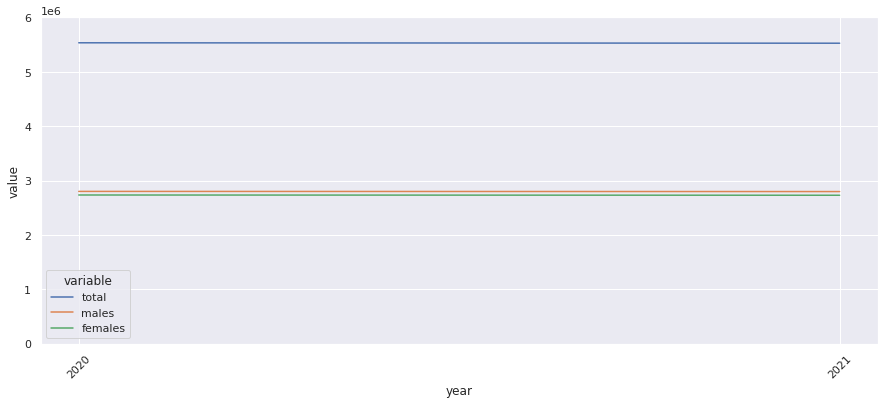

In [22]:
plot_population_development(results)

### Life expectancy analysis

To demonstrate law of large numbers we do following:

1. Kernel density estimate (KDE) distribution of death ages on given year
2. Sample from kernel density estimated distribution
3. Use sample from the step 2 to Monte Carlo estimate lifetime expectancy on given year.

#### Gaussian kernel density estimation of the death age distribution

Kernel density estimation is a non-parametric method for estimating density function of a distribution.

$$
\begin{gather}
\textrm{Let }x_1, x_2, ..., x_n\textrm{ be an i.i.d sample from the unknown distribution }f(x).\newline
\textrm{Now kernel density estimator }\hat{f}(x)\textrm{ of the distribution }f(x)\textrm{ is defined as:}\newline
\hat{f}(x)=\frac{1}{nh}\sum_{i=1}^{n} K(\frac{x - x_i}{h})\newline
\textrm{where }K \textrm{ is the kernel function and }h > 0\textrm{ is a smoothing parameter.}\newline
\textrm{Kernel function must satisfy}\newline
\int_{-\infty}^{\infty}K(x)dx=1\newline
\textrm{Gaussian kernel is defined as:}\newline
K(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}
\end{gather}
$$

Here we choose $h = 1$ as a smoothing parameter value because it feels quite natural for the age and seems to produce reasonable results. Kernel density estimation distribution can be seen from the figure below on the top right corner (e.g. "KDE for original 2021 distribution").

#### Law of large numbers demonstration

Strong law of large numbers states that

$$
\begin{gather}
\textrm{Let }\mu=\mathbb {E}(X)\textrm{ then}\newline
\overline{X}_{n}\xrightarrow{\text{a.s.}} \mu \qquad {\textrm {when}}\ n\to \infty\newline
\end{gather}
$$

Now we want to estimate the lifetime expectancy given sex and simulation year $\mathbb {E}(X|X_{sex},T_{year})$.

We previously showed a method for approximating density function of a distribution with kernel density estimation. Now it is reasonable to approximate death age distribution given year and simulation $f(X_{death\ age}|X_{sex},T_{year})$ with continuous KDE estimate $\hat{f}_{KDE}(X_{death\ age}|X_{sex},T_{year})$.

$$
\begin{gather}
\textrm{Now}\newline
f(X_{death\ age}|X_{sex},T_{year}) \approx \hat{f_{KDE}}(X_{death\ age}|X_{sex},T_{year})\newline
\textrm{Let }X_i \sim \hat{f_{KDE}}(X_{death\ age}|X_{sex},T_{year})\qquad i.i.d\newline
\textrm{Now because}\newline
\mathbb {E}(X_{death\ age}|X_{sex},T_{year})=\int_{0}^{max\ age}x\ f(X_{death\ age}|X_{sex},T_{year})dx\newline
\textrm{We can approximate distribution with KDE estimated distribution and utilize} \newline \textrm{strong law of large numbers to Monte Carlo approximate conditional expectation by sampling the KDE distribution}\newline
\mathbb {E}(X_{death\ age}|X_{sex},T_{year}) \approx \sum_{i=1}^{n} x_{i,death\ age} \hat{f_{KDE}}(x_{i, death\ age}|x_{i,sex},T_{year})
\end{gather}
 $$

Results of the Monte Carlo approximate traceplot we can see from the bottom right corner of the figure below (e.g. "Traceplot for 2021 life expectancy Monte Carlo estimation"). We see that the estimate of the lifetime expectancy converges as n increases.

In [23]:
def kde_distribution(data):
    kde = KernelDensity(bandwidth=1, kernel='gaussian')
    kde.fit(data.reshape(-1, 1))
    
    return kde


def plot_kde(kde, ax, title):
    data_grid = np.linspace(0, Cfg.MAX_AGE, 1000)
    logprob = kde.score_samples(data_grid.reshape(-1, 1))
    prob = np.exp(logprob)
    mp = ax.fill_between(data_grid.reshape(-1), prob, alpha=0.3)
    ax.set_title(title)

    
def sample_from_kde(kde, n=1000):
    return kde.sample(n, random_state=42).reshape(-1)


def plot_histogram_of_ages(samples, ax, title):
    mp = sns.histplot(samples, binrange=(0, Cfg.MAX_AGE + 1), binwidth=1, ax=ax)
    mp.set_title(title)
    ax.set(ylabel='Count')
    ax.set(xlabel='Age')

    
def plot_monte_carlo_life_expectancy(samples, ax, title):
    idx = np.arange(1, len(samples) + 1)
    mcle_cumsum = np.cumsum(samples) / idx
    mp = sns.lineplot(x=idx, y=mcle_cumsum, ax=ax)
    estimated_life_expectancy = mcle_cumsum[-1]
    mp.set_title(title + f"\n Estimated lifetime expectancy {round(estimated_life_expectancy, 1)}")
    
    return round(estimated_life_expectancy, 1)


def lifetime_expectancy_analysis(year, sex):
    fig, ax = plt.subplots(2, 2, figsize=(Cfg.A4_DIMS[0], Cfg.A4_DIMS[1]*2))
    death_age_data = dead_df[(dead_df['death_year'] == year) & (dead_df['sex'] == sex)]['age'].to_numpy()
    plot_histogram_of_ages(death_age_data, ax[0, 0], f"Original simulated {year} distribution")
    death_age_kde = kde_distribution(death_age_data)
    plot_kde(death_age_kde, ax[0, 1], f"KDE for original {year} distribution")
    death_age_samples = sample_from_kde(death_age_kde)

    plot_histogram_of_ages(death_age_samples, ax[1, 0], title=f"Samples from {year} KDE")
    plot_monte_carlo_life_expectancy(death_age_samples, ax[1, 1], f"Traceplot for {year} life expectancy Monte Carlo estimation")

#### Lifetime expectancy 2021 (first simulation year)

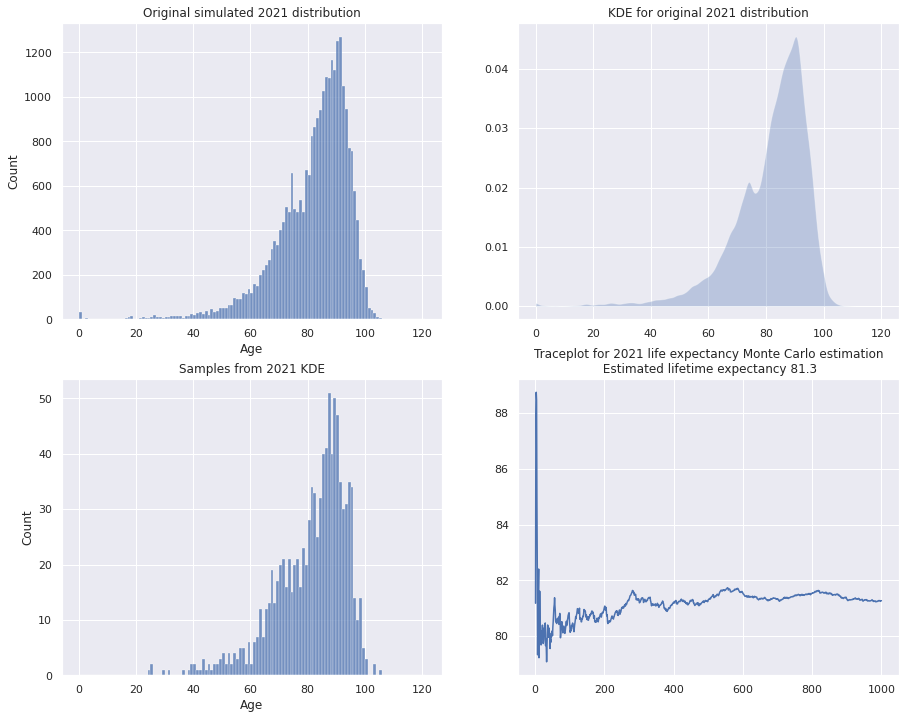

In [24]:
# Females
lifetime_expectancy_analysis(2021, 0)

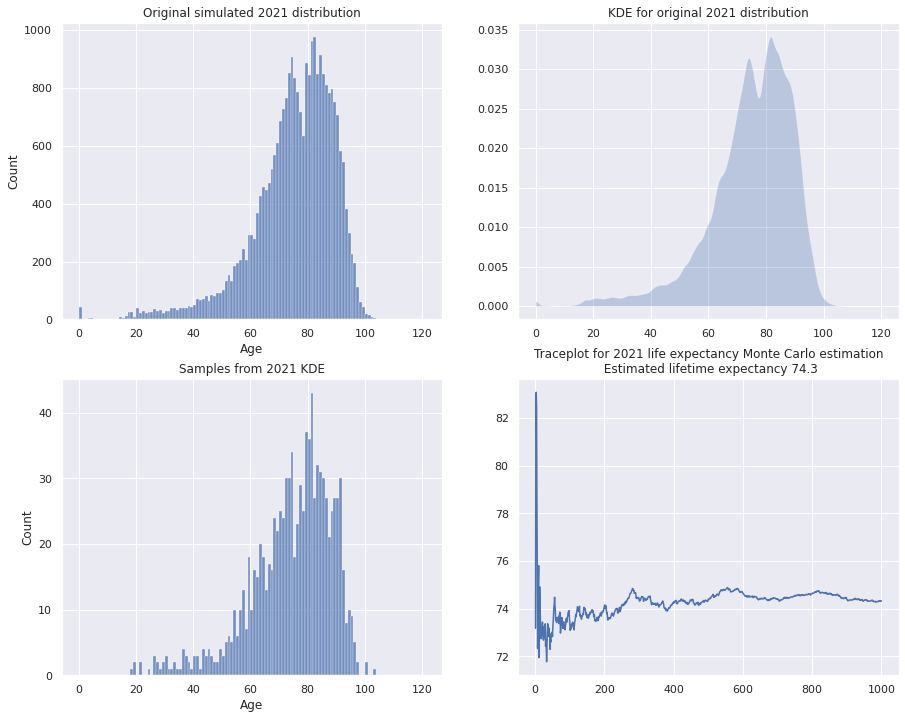

In [25]:
# Males
lifetime_expectancy_analysis(2021, 1)

#### Lifetime expectancy 2075

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

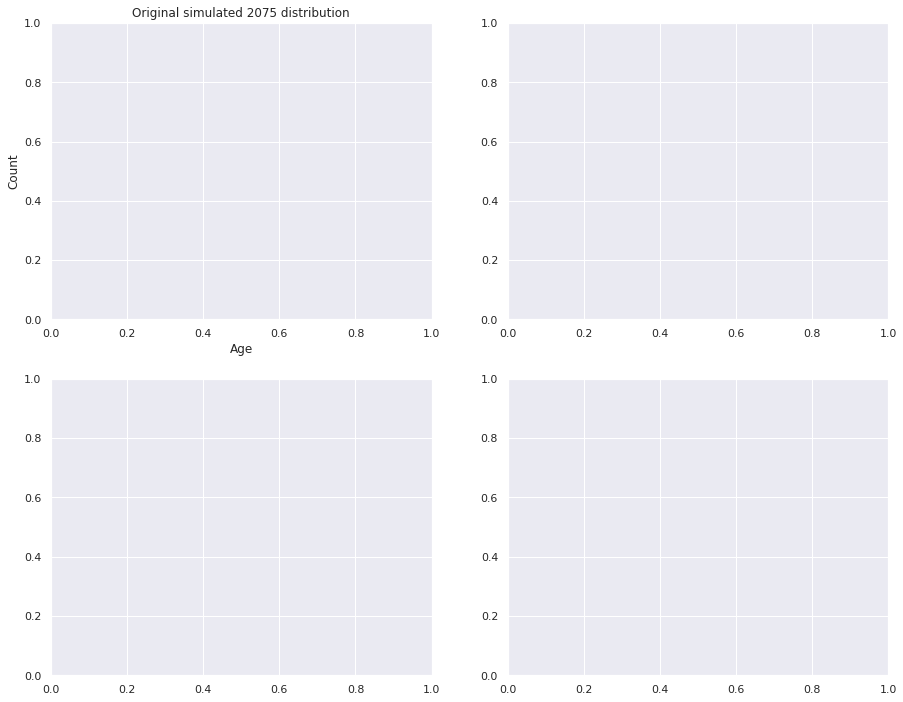

In [26]:
# Females
lifetime_expectancy_analysis(2075, 0)

In [ ]:
# Males
lifetime_expectancy_analysis(2075, 1)

In [ ]:
def double_check_life_expectancies():
    males = stats_lifetime_df[stats_lifetime_df['sex'] == 0]
    avg_males_death_age = np.sum(males['age'] * males['dead_count']) / np.sum(males['dead_count'])
    females = stats_lifetime_df[stats_lifetime_df['sex'] == 1]
    avg_females_death_age = np.sum(females['age'] * females['dead_count']) / np.sum(females['dead_count'])
    print(f"Males average death age in {Cfg.INITIAL_YEAR}: {round(avg_males_death_age, 1)}")
    print(f"Females average death age in {Cfg.INITIAL_YEAR}: {round(avg_females_death_age, 1)}")


double_check_life_expectancies()

#### Comparison to statistics Finland official estimate of the lifetime expectancy

Statistics Finland [official lifetime expectancy for 2020](https://www.stat.fi/til/kuol/2020/01/kuol_2020_01_2021-10-22_tie_001_en.html) states that "Average life expectancy at birth was exactly 79 years for boys and 84.6 years for girls in 2020". This is **not inline** with our results. Not even when (double) checked against our source data from statistics Finland source data (see double_check_life_expectancies() cell above) and not when using Monte Carlo approximate. This must be due to fact that calculation methods shown here for lifetime expectancy are not the same as with official ones. So it looks like lifetime expectancy as defined in this notebook does not fullfil the real lifetime expectancy definition. Definition should be further investigated but because the purpose of this notebook is not to provide accurate numbers we can live with that. Initially I borrowed definition of the lifetime expectancy loosely from [Finnish Wikipedia](https://fi.wikipedia.org/wiki/Elinajanodote) which states: "Elinajanodote on tilastollinen suure, joka kuvaa tietyn väestön keskimääräistä kuolinikää. ... Vastoin yleistä väärinkäsitystä, ensisijainen tarkoitus ei ole ennustaa tulevaisuutta (vrt. elinajan ennuste)."

Nonetheless results look superficially sufficient. E.g. females have higher life time expectancy and lifetime expectanies tend to grow over time.